In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Data pre-processing 

Note that the data pre-processing work is done based on extensive experimentation in other codes in the repository. This work is done based on earlier pre-processing.

Steps:
- Load in pre-processed dataset: any rows or columns with >70% of values missing are dropped; records with no outcome attribute value also dropped; date converted to integer encoding and location converted to longitude and latitude; categorical data converted to one hot encodings; missing values imputed with kNN classifier
- 15-day rolling sum of last days rain attribute was added
- Oversampling performed with SMOTE
- Feature selection done with SelectKBest class



In [ ]:
#Load in pre-processed dataset. NOTE for TA: The relevant dataset on the GitHub is titled imputedDatasetKnn. This can be uploaded to your Google Drive and then be loaded. 

dataset = np.load('/content/drive/MyDrive/imputedDatasetKnn.npy')

In [ ]:
#Dataset viewed as a dataframe.
df = pd.DataFrame(data = dataset)
df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,335.0,-36.080477,146.916280,13.4,22.9,0.6,6.115968,8.392075,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.359052,16.9,21.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0
1,336.0,-36.080477,146.916280,7.4,25.1,0.0,6.094795,7.951022,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.157463,4.620381,17.2,24.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008493,0.007864,0.043431,0.040518,0.066378,0.008312,0.041809,0.007873,0.238504,0.009772,0.010856,0.009308,0.008155,0.009348,0.212463,0.276916,0.0,1.0,1.0,0.0
2,337.0,-36.080477,146.916280,12.9,25.7,0.0,5.848119,8.049394,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.078061,2.000000,21.0,23.2,0.004442,0.040214,0.037089,0.004499,0.034924,0.003458,0.00315,0.076421,0.039984,0.041434,0.075146,0.004404,0.004217,0.004308,0.440991,0.185318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.004368,0.040345,0.004389,0.001894,0.071507,0.004275,0.003374,0.004049,0.135167,0.005026,0.075566,0.041839,0.073505,0.004808,0.326865,0.203021,0.0,1.0,1.0,0.0
3,338.0,-36.080477,146.916280,9.2,28.0,0.0,7.083852,9.072607,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,3.723490,4.084023,18.1,26.5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0
4,339.0,-36.080477,146.916280,17.5,32.3,1.0,6.043189,7.379243,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142027,171.0,-25.344857,131.032517,3.5,21.8,0.0,4.781259,8.180025,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,3.483625,3.314090,9.4,20.9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0
142028,172.0,-25.344857,131.032517,2.8,23.4,0.0,4.716664,7.950832,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,3.401886,3.424317,10.1,22.4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0
142029,173.0,-25.344857,131.032517

In [ ]:
#Insert an attribute that obtains a rolling sum of the number of times rained in last 15 days.
df.insert(0, 'LastDays', df[70].rolling(15).sum().shift(1))

In [ ]:
dataset = df.to_numpy()

In [ ]:
import sys
!pip install impyute
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

#Fill in null values from inserting LastDays using a kNN classifier. Only 15 null values result. 
dataset = fast_knn(dataset.astype('float'), k=30)

In [ ]:
dataset

array([[  2.24364841, 335.        , -36.0804766 , ...,   1.        ,
          1.        ,   0.        ],
       [  2.07107718, 336.        , -36.0804766 , ...,   1.        ,
          1.        ,   0.        ],
       [  2.25090917, 337.        , -36.0804766 , ...,   1.        ,
          1.        ,   0.        ],
       ...,
       [  0.        , 173.        , -25.344857  , ...,   1.        ,
          1.        ,   0.        ],
       [  0.        , 174.        , -25.344857  , ...,   1.        ,
          1.        ,   0.        ],
       [  0.        , 175.        , -25.344857  , ...,   1.        ,
          1.        ,   0.        ]])

In [ ]:
from sklearn.preprocessing import StandardScaler

#We need to ensure that the entire last two columns are not included, as they express the "RainTomorrow" attribute in tandem. 
X = dataset[:, :-2]
#Squeeze out extra dimension as we are dealing with one value per entry.
y = dataset[:, -1:].squeeze()


# Standardizing the features
X = StandardScaler().fit_transform(X)
print(X)

[[-0.42261527  1.48606168 -0.57503158 ...  3.89349463 -0.13622435
   0.13622435]
 [-0.48784761  1.49559146 -0.57503158 ...  0.87568703 -0.13622435
   0.13622435]
 [-0.41987068  1.50512124 -0.57503158 ...  0.5672847  -0.13622435
   0.13622435]
 ...
 [-1.27071976 -0.05776303  1.13551027 ... -0.28002595 -0.13622435
   0.13622435]
 [-1.27071976 -0.04823325  1.13551027 ...  3.89349463 -0.13622435
   0.13622435]
 [-1.27071976 -0.03870347  1.13551027 ... -0.28002595 -0.13622435
   0.13622435]]


In [ ]:
#Using SelectKBest of sklearn.feature_selection.
#ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


#Through manual experimentation, best value for the k parameter is 60. 
fs = SelectKBest(score_func=f_classif, k = 60)
#Apply feature selection.
X = fs.fit_transform(X, y)
print(X.shape)


(142032, 60)


In [ ]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.30)
print("The percentage of rainy days in training set is " + str(trainY.tolist().count(1)/(trainY.tolist().count(0) + trainY.tolist().count(1))))
print("The percentage of rainy days in test set is " + str(testY.tolist().count(1)/(testY.tolist().count(0) + testY.tolist().count(1))))

The percentage of rainy days in training set is 0.2249300959546177
The percentage of rainy days in test set is 0.22215442384416803


In [ ]:
# %pip install -U imbalanced-learn
# !pip install delayed
import sklearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors = 10)
X_train_res, y_train_res = sm.fit_resample(trainX, trainY)

trainX = X_train_res
trainY = y_train_res

print("The percentage of rainy days in the training set is " + str(y_train_res.tolist().count(1)/(y_train_res.tolist().count(0) + y_train_res.tolist().count(1))))
print("The percentage of rainy days in the test set is " + str(testY.tolist().count(1)/(testY.tolist().count(0) + testY.tolist().count(1))))

The percentage of rainy days in the training set is 0.5
The percentage of rainy days in the test set is 0.22215442384416803


In [ ]:
print("The number of records in the training set is " + str(len(trainX)))
print("The number of records in the testing set is " + str(len(testX)))

The number of records in the training set is 154118
The number of records in the testing set is 42610


## Final Model

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

modelFinal = CatBoostClassifier(learning_rate=0.3, depth=10, l2_leaf_reg=9)
modelFinal.fit(trainX, trainY, verbose=0)

from sklearn.metrics import classification_report, confusion_matrix
predY = modelFinal.predict(testX)

print(classification_report(testY, predY))


     |████████████████████████████████| 67.3MB 44kB/s 
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     33144
         1.0       0.72      0.60      0.65      9466

    accuracy                           0.86     42610
   macro avg       0.81      0.77      0.78     42610
weighted avg       0.85      0.86      0.85     42610



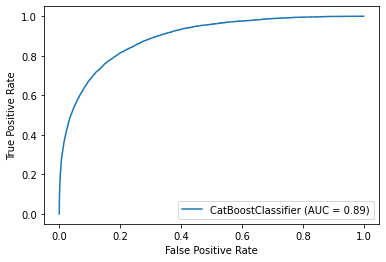

In [ ]:
from sklearn import datasets, metrics, model_selection
metrics.plot_roc_curve(modelFinal, testX, testY)  